## ewf-ext-02-03-02 - NDVI growing season statistics time series per pixel

NDVI growing season statistics time series per pixel

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'NDVI growing season statistics time series per pixel'),
                ('abstract', 'NDVI growing season statistics time series per pixel'),
                ('id', 'ewf-ext-02-03-02')])

### <a name="parameter">Parameter Definition 

In [2]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [3]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'Leziria'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the NDVI stack of products' identifiers

In [4]:
input_identifiers = ('LE07_L1TP_204033_20170725_20170820_01_T1_SR_NDVI.TIF', 'LE07_L1TP_204033_20170810_20170905_01_T1_SR_NDVI.TIF', 'LE07_L1TP_204033_20170911_20171007_01_T1_SR_NDVI.TIF', 'LE07_L1TP_204033_20170927_20171023_01_T1_SR_NDVI.TIF', 'LE07_L1TP_204033_20171114_20171210_01_T1_SR_NDVI.TIF', 'LE07_L1TP_204033_20171130_20171226_01_T1_SR_NDVI.TIF')

**Input references**

This is the NDVI stack catalogue references

In [5]:
input_references = tuple(['https://catalog.terradue.com/modis/search?uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [6]:
data_path = "/workspace/Landsat/data/output01"

**Aux folders**

In [7]:
output_folder = ''

In [8]:
temp_folder = 'temp'

#### Import Modules

In [9]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import matplotlib
import matplotlib.pyplot as plt

import datetime

import pdb

#### Auxiliary vars

In [10]:
check_results = True

#### Auxiliary methods

In [11]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            
def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list



def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type

def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)



        
        
        
def get_formatted_date(datetime_str):
    date = datetime.datetime.strftime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    
    first_date_str = datetime.datetime(year=first_date.year, month=first_date.month, day=first_date.day)
    first_date_str = first_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    first_date_str = get_formatted_date(first_date_str)
    
    last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
    last_date_str = last_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    last_date_str = get_formatted_date(last_date_str)
    
    if (first_date_str == last_date_str):
        last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
        last_date_str = last_date_str + datetime.timedelta(days=0, hours=23, minutes=59, seconds=59)
        last_date_str = get_formatted_date(last_date_str)
    
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))

#### Auxiliary folders

In [12]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

Load NDVI images

In [13]:
file_list = [os.path.join(data_path, file_name.split('/')[-1]) for file_name in input_identifiers]

img_mat_list = get_matrix_list(file_list)

In [14]:
#dt = datetime.strptime(ind[17:25], "%Y%m%y")

dates_str = [ind[17:25] for ind in input_identifiers]

dates = [datetime.datetime.strptime(ind[17:25], "%Y%m%d") for ind in input_identifiers]

print(dates)

[datetime.datetime(2017, 7, 25, 0, 0), datetime.datetime(2017, 8, 10, 0, 0), datetime.datetime(2017, 9, 11, 0, 0), datetime.datetime(2017, 9, 27, 0, 0), datetime.datetime(2017, 11, 14, 0, 0), datetime.datetime(2017, 11, 30, 0, 0)]


(-1.0, 1.0)
(-1.0, 1.0)
(-1.0, 1.0)
(-1.0, 1.0)
(-1.0, 1.0)
(-1.0, 1.0)


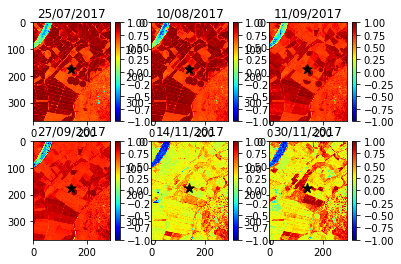

In [15]:
if check_results:
    
    point = [225, 140]
    
    point = [175, 140]
    
    #point = [75, 50]
    
    #point = [350, 60]

    #fig = plt.figure()
    #plt.imshow(img_mat_list[0])
    #plt.show()
    
    pass
    



    nrows = 2
    ncols = 3
    for plot_number, img in zip(range(len(img_mat_list)), img_mat_list):
        
        plt.subplot(nrows, ncols, plot_number+1)
        
        plt.title(dates[plot_number].strftime("%d/%m/%Y"))

        
        plt.imshow(img, cmap='jet', vmin=-1, vmax=1)
        
        plt.colorbar()
        
        plt.scatter(point[1], point[0], s=100, c='black', marker='*')
        
        
        
        
        print(img.min(), img.max())
    
   

    #plt.savefig('ndvi_maps.png', dpi=300)
    plt.show()

    
    

def get_formatted_date(datetime_str):
    date = datetime.datetime.strftime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
 
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    
    first_date_str = datetime.datetime(year=first_date.year, month=first_date.month, day=first_date.day)
    first_date_str = first_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    first_date_str = get_formatted_date(first_date_str)
    
    last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
    last_date_str = last_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    last_date_str = get_formatted_date(last_date_str)
    
    if (first_date_str == last_date_str):
        last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
        last_date_str = last_date_str + datetime.timedelta(days=0, hours=23, minutes=59, seconds=59)
        last_date_str = get_formatted_date(last_date_str)

    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date_str, last_date_str))
        file.write('geometry=%s' % (region_of_interest))

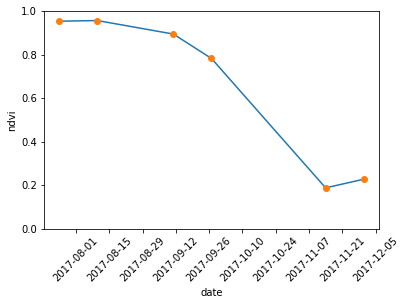

[0.95389074, 0.956975, 0.89474463, 0.7825536, 0.1874923, 0.22717857]

In [16]:
# show NDVi time series for a given pixel
# print(img_mat_list[0][230, 150])


if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in img_mat_list]
    
    fig = plt.figure()
    
    plt.plot(dates, ndvi_values, '-')
    plt.plot(dates, ndvi_values, 'o')
    
    plt.ylim((0, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()
    
ndvi_values


Calculation of NDVI differences between consecutive images

In [17]:


def get_ndvi_diffs (matrix_img_list):
    
    dif_matrix_img_list = []
    for i in range(len(matrix_img_list) - 1):
        
        diff = matrix_img_list[i+1] - matrix_img_list[i]
        
        dif_matrix_img_list.append(diff)
        
    return dif_matrix_img_list
        
dif_matrix_img_list = get_ndvi_diffs (img_mat_list)



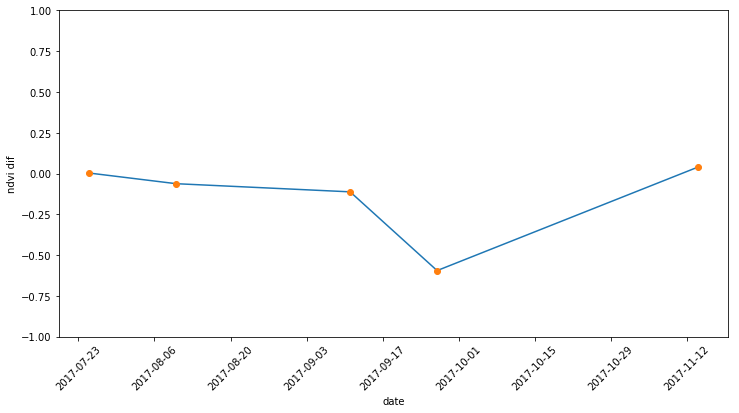

In [18]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in dif_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates[:-1], ndvi_values, '-')
    plt.plot(dates[:-1], ndvi_values, 'o')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi dif')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()

Cumulative NDVI value for growing season

In [19]:

def get_ndvi_cumulative (matrix_img_list):
    
    cumulative_matrix_img_list = []
    
    cum_ndvi = []
    for idx,img_ndvi in enumerate(matrix_img_list):
        if idx == 0:
            cum_ndvi = img_ndvi
        else:
            cum_ndvi = cum_ndvi + img_ndvi
        
        cumulative_matrix_img_list.append(cum_ndvi)
        
    return cumulative_matrix_img_list
        
cumulative_matrix_img_list = get_ndvi_cumulative (img_mat_list)

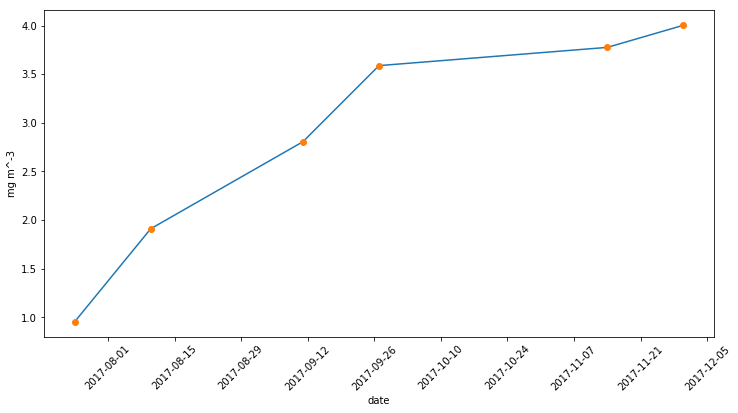

In [20]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates, ndvi_values, '-')
    plt.plot(dates, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()

Cumulative NDVI value for growing season

In [21]:

def get_inverse_ndvi_cumulative (matrix_img_list):
    
    inv_cumulative_matrix_img_list = []
    
    inv_cum_ndvi = []
    for idx,img_ndvi in enumerate(reversed(matrix_img_list)):
        
        
        
        if idx == 0:
            inv_cum_ndvi = img_ndvi
        else:
            inv_cum_ndvi = inv_cum_ndvi + img_ndvi
            
        
        
        inv_cumulative_matrix_img_list.append(inv_cum_ndvi)
        
    return list(reversed(inv_cumulative_matrix_img_list))
        
inv_cumulative_matrix_img_list = get_inverse_ndvi_cumulative (img_mat_list)

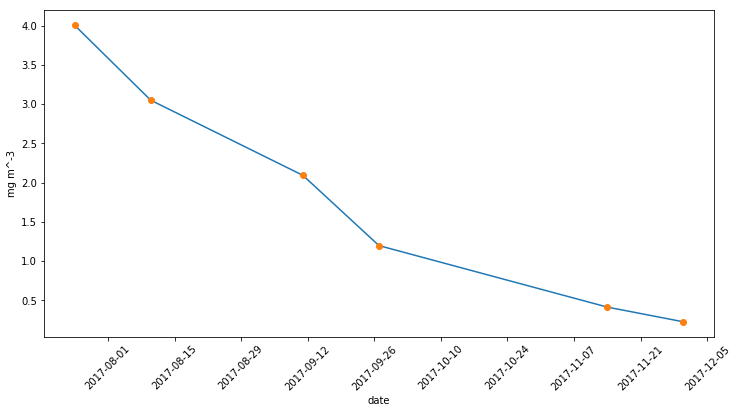

[4.002835, 3.048944, 2.091969, 1.1972245, 0.41467088, 0.22717857]


In [22]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates, ndvi_values, '-')
    plt.plot(dates, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()
    
    print(ndvi_values)

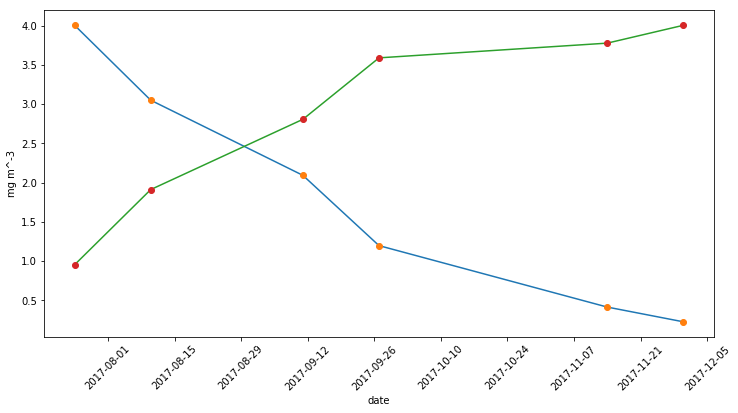

[0.95389074, 1.9108658, 2.8056104, 3.588164, 3.7756565, 4.0028353]


In [23]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates, ndvi_values, '-')
    plt.plot(dates, ndvi_values, 'o')
    
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]
    
    
    
    plt.plot(dates, ndvi_values, '-')
    plt.plot(dates, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()
    
    print(ndvi_values)

NDVI peak value

In [24]:
def get_ndvi_peak (matrix_img_list):
  
    peak_ndvi = []
    for idx,img_ndvi in enumerate(matrix_img_list):
        if idx == 0:
            peak_ndvi = img_ndvi
        else:
            peak_ndvi = np.where(peak_ndvi < img_ndvi, img_ndvi, peak_ndvi)
        
    return peak_ndvi
        
peak_matrix_img = get_ndvi_peak (img_mat_list)

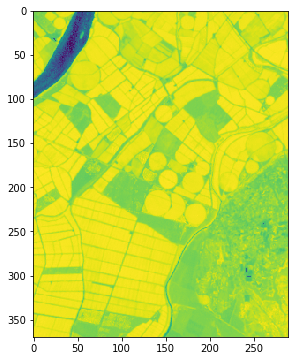

1.0
-0.4580686


In [25]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(peak_matrix_img)
    
    plt.show()
    
    print(peak_matrix_img.max())
    print(peak_matrix_img.min())

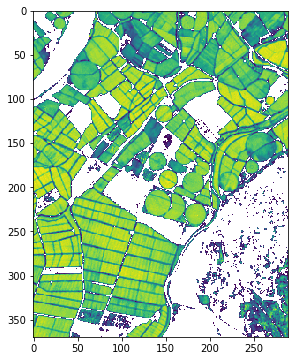

1.0
-0.4580686


In [26]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt
    
    import numpy.ma as ma

    fig = plt.figure()
    
    mx = ma.masked_array(peak_matrix_img, mask = peak_matrix_img < 0.8)
    
    plt.imshow(mx)
    
    plt.show()
    
    print(peak_matrix_img.max())
    print(peak_matrix_img.min())


Start date of the growing season (based on evolution of NDVI values over growing season)

In [27]:
c   = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]
inv_c = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]

def get_start_and_end_idx_array (cumulative, inv_cumulative, tol_thr=0.2):
    
    tol_c = (max(cumulative) - min(cumulative)) * tol_thr
    tol_inv_c = (max(inv_cumulative) - min(inv_cumulative)) * tol_thr
    
    
    print(tol_c)
    print(tol_inv_c)
    
    #pdb.set_trace()
    
    start_idx = 0
    for i in range(len(cumulative)-1):
        
        
        
        if i == 0:
        
            dif = cumulative[i+1] - cumulative[i]
        
            if (dif > tol_c):
            
                start_idx = i
            
                break
                
            start_idx = i
            
        else:
            
            m1stpair = cumulative[0] + (cumulative[1] - cumulative[0])/2.0
            
            dif = cumulative[i+1] - m1stpair
            
            if dif > tol_c:
            
                start_idx = i
            
                break
                
            start_idx = i
    
    
    end_idx = 0
    for i in range(len(inv_cumulative)-1):
        
        
        
        if i == 0:
        
            dif = inv_cumulative[i+1] - inv_cumulative[i]
        
            if (dif > tol_inv_c):
            
                end_idx = i
            
                break
                
            end_idx = i
            
        else:
            
            m1stpair = inv_cumulative[0] + (inv_cumulative[1] - inv_cumulative[0])/2.0
            
            dif = inv_cumulative[i+1] - m1stpair
            
            if dif > tol_inv_c:
            
                end_idx = i
            
                break
                
            end_idx = i
    
    
    return start_idx, end_idx

c = [0.95389074, 0.95389074, 1.6, 1.9108658, 2.8056104, 3.588164, 3.7756565, 4.0028353]
inv_c = [4.002835, 3.048944, 2.091969, 1.1972245, 0.41467088, 0.22717857]

print(c)
print(inv_c)

print(get_start_and_end_idx_array (c, inv_c, 0.2))



[0.95389074, 0.95389074, 1.6, 1.9108658, 2.8056104, 3.588164, 3.7756565, 4.0028353]
[4.002835, 3.048944, 2.091969, 1.1972245, 0.41467088, 0.22717857]
0.609788912
0.755131286
(1, 4)


In [28]:




def get_start_and_end_date (cumulative_matrix_img_list, inv_cumulative_matrix_img_list, peak_matrix_img):
  
    peak_ndvi = []
    for idx,img_ndvi in enumerate(matrix_img_list):
        if idx == 0:
            peak_ndvi = img_ndvi
        else:
            peak_ndvi = np.where(peak_ndvi < img_ndvi, img_ndvi, peak_ndvi)
        
    return peak_ndvi
        
#peak_matrix_img = get_ndvi_peak (img_mat_list)

End date of the growing season (based on evolution of NDVI values over growing season)

#### Check results

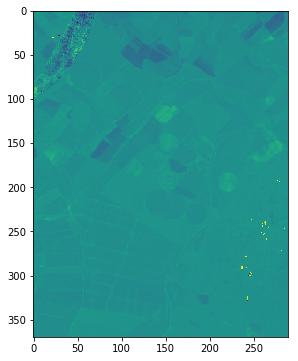

In [29]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(dif_matrix_img_list[0])
    plt.show()

#### Saves Results

In [30]:
add0 = lambda x : x if len(x) > 1 else '0' + x

projection, geotransform, no_data_value, data_type = get_metadata(file_list[0])
    

Output NDVI differences between consecutive images

In [31]:
var_name = 'difs'

first_part = input_identifiers[0][0:9]
second_part = input_identifiers[0][35:-4]

for idx, img in enumerate(dif_matrix_img_list):
    
    start_date_str = str(dates[idx+1].year) + add0(str(dates[idx+1].month)) + add0(str(dates[idx+1].day))
    end_date_str = str(dates[idx].year) + add0(str(dates[idx].month)) + add0(str(dates[idx].day))
    
    dif_ndvi_img_name = '_'.join([first_part, second_part, var_name, start_date_str, end_date_str]) + '.tif'
    
    dif_ndvi_img_name = os.path.join(output_folder, dif_ndvi_img_name)
    
    print(dif_ndvi_img_name)

    write_output_image(dif_ndvi_img_name, img, 'GTiff', data_type, None, projection, geotransform, no_data_value)

    write_properties_file(dif_ndvi_img_name, dates[idx], dates[idx+1], regionOfInterest['value'])

LE07_L1TP_01_T1_SR_NDVI_difs_20170810_20170725.tif
LE07_L1TP_01_T1_SR_NDVI_difs_20170911_20170810.tif
LE07_L1TP_01_T1_SR_NDVI_difs_20170927_20170911.tif
LE07_L1TP_01_T1_SR_NDVI_difs_20171114_20170927.tif
LE07_L1TP_01_T1_SR_NDVI_difs_20171130_20171114.tif


Output NDVI peak value

In [32]:
var_name = 'cumulative'

start_date_str = str(dates[0].year) + add0(str(dates[0].month)) + add0(str(dates[0].day))

first_part = input_identifiers[0][0:9]
second_part = input_identifiers[0][35:-4]


for idx, img in enumerate(cumulative_matrix_img_list):
    
    end_date_str = str(dates[idx].year) + add0(str(dates[idx].month)) + add0(str(dates[idx].day))

    
    cum_ndvi_img_name = '_'.join([first_part, second_part, var_name, start_date_str, end_date_str]) + '.tif'
    
    cum_ndvi_img_name = os.path.join(output_folder, cum_ndvi_img_name)
    
    print(cum_ndvi_img_name)

    write_output_image(cum_ndvi_img_name, img, 'GTiff', data_type, None, projection, geotransform, no_data_value)

    write_properties_file(cum_ndvi_img_name, dates[0], dates[idx], regionOfInterest['value'])

LE07_L1TP_01_T1_SR_NDVI_cumulative_20170725_20170725.tif
LE07_L1TP_01_T1_SR_NDVI_cumulative_20170725_20170810.tif
LE07_L1TP_01_T1_SR_NDVI_cumulative_20170725_20170911.tif
LE07_L1TP_01_T1_SR_NDVI_cumulative_20170725_20170927.tif
LE07_L1TP_01_T1_SR_NDVI_cumulative_20170725_20171114.tif
LE07_L1TP_01_T1_SR_NDVI_cumulative_20170725_20171130.tif


In [33]:
var_name = 'peak'

start_date_str = str(dates[0].year) + add0(str(dates[0].month)) + add0(str(dates[0].day))
end_date_str = str(dates[-1].year) + add0(str(dates[-1].month)) + add0(str(dates[-1].day))

first_part = input_identifiers[0][0:9]
second_part = input_identifiers[0][35:-4]

    
peak_ndvi_img_name = '_'.join([first_part, second_part, var_name, start_date_str, end_date_str]) + '.tif'
    
peak_ndvi_img_name = os.path.join(output_folder, peak_ndvi_img_name)
    
print(peak_ndvi_img_name)

write_output_image(peak_ndvi_img_name, peak_matrix_img, 'GTiff', data_type, None, projection, geotransform, no_data_value)

write_properties_file(peak_ndvi_img_name, dates[0], dates[-1], regionOfInterest['value'])

LE07_L1TP_01_T1_SR_NDVI_peak_20170725_20171130.tif


Output Start date of the growing season

In [34]:
# TODO

Output End date of the growing season

In [35]:
# TODO

#### Remove temporay files and folders

In [ ]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)